In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sb
import warnings; warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset
dataset = load_dataset("SetFit/emotion")

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})


In [4]:
df_train = pd.DataFrame(dataset['train'])
df_train.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


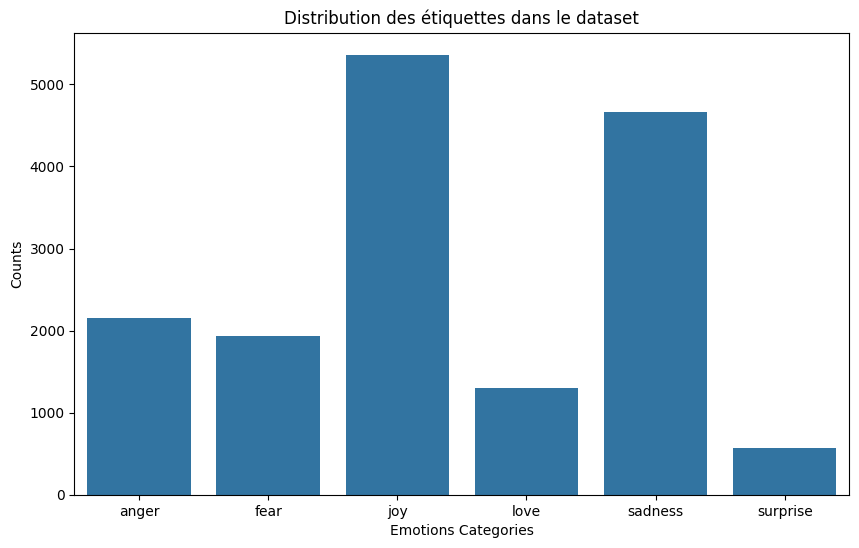

In [5]:

label_counts = df_train.groupby("label_text").size().reset_index(name='counts')

plt.figure(figsize=(10, 6))
sb.barplot(x="label_text", y="counts", data=label_counts)

plt.title("Distribution des étiquettes dans le dataset")
plt.xlabel("Emotions Categories")
plt.ylabel("Counts")

plt.show()

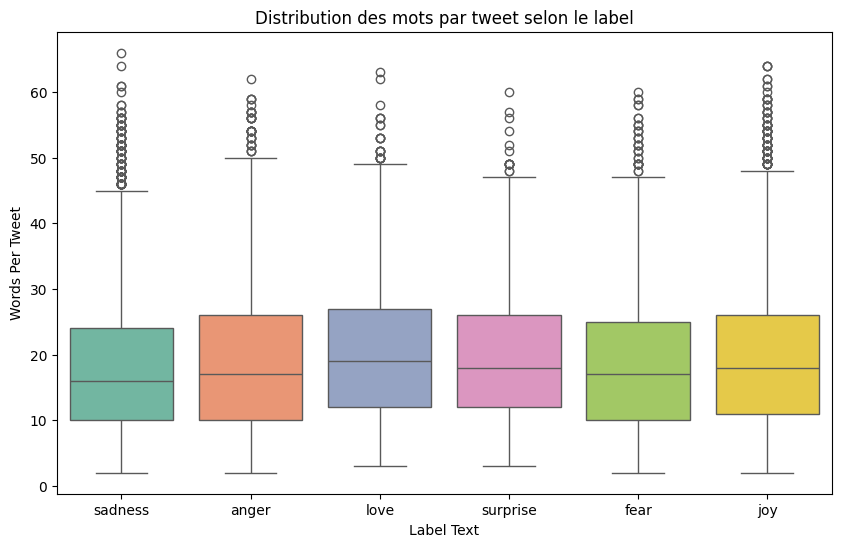

In [6]:
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)
plt.figure(figsize=(10, 6))
sb.boxplot(x="label_text", y="Words Per Tweet", data=df_train, palette="Set2")

plt.title("Distribution des mots par tweet selon le label")
plt.xlabel("Label Text")
plt.ylabel("Words Per Tweet")

plt.show()

In [7]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenise(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [8]:
emotions_encoded_train = dataset['train'].map(tokenise, batched=True, batch_size=None)
print(emotions_encoded_train.column_names)

emotions_encoded_test = dataset['test'].map(tokenise, batched=True, batch_size=None)

['text', 'label', 'label_text', 'input_ids', 'attention_mask']


In [9]:
from transformers import AutoModelForSequenceClassification
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 6

model_ckpt = "distilbert-base-uncased"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, 
                          num_labels=num_labels)
         .to(device))


from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}




from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(emotions_encoded_train) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False, 
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")






import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded_test,
                  eval_dataset=emotions_encoded_train,
                  tokenizer=tokenizer)
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-11-12 13:38:16.491880: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.454299807548523, 'eval_accuracy': 0.5394375, 'eval_f1': 0.41628410505366475, 'eval_runtime': 1140.1176, 'eval_samples_per_second': 14.034, 'eval_steps_per_second': 0.219, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.2187597751617432, 'eval_accuracy': 0.5759375, 'eval_f1': 0.4504676841684915, 'eval_runtime': 2098.2948, 'eval_samples_per_second': 7.625, 'eval_steps_per_second': 0.119, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 1.171615481376648, 'eval_accuracy': 0.5796875, 'eval_f1': 0.45461051520887336, 'eval_runtime': 1329.3477, 'eval_samples_per_second': 12.036, 'eval_steps_per_second': 0.188, 'epoch': 3.0}
{'train_runtime': 5821.9745, 'train_samples_per_second': 1.031, 'train_steps_per_second': 0.016, 'train_loss': 1.338948408762614, 'epoch': 3.0}


TrainOutput(global_step=96, training_loss=1.338948408762614, metrics={'train_runtime': 5821.9745, 'train_samples_per_second': 1.031, 'train_steps_per_second': 0.016, 'total_flos': 102462562224000.0, 'train_loss': 1.338948408762614, 'epoch': 3.0})

In [25]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

texts = ["I'm so happy!", "I feel really sad today.", "This is frustrating.", "Kamala broke it but I will fix it", "I am sitting on the carpet alone", "I am sitting on the carpet with a girl"]
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    preds = outputs.logits.argmax(dim=-1).cpu().numpy()

for i, text in enumerate(texts):
    label_text = label_map.get(preds[i], "unknown")
    print(f"Texte : '{text}'")
    print(f"  Prédiction : {preds[i]} ({label_text})")



Texte : 'I'm so happy!'
  Prédiction : 1 (joy)
Texte : 'I feel really sad today.'
  Prédiction : 0 (sadness)
Texte : 'This is frustrating.'
  Prédiction : 0 (sadness)
Texte : 'Kamala broke it but I will fix it'
  Prédiction : 1 (joy)
Texte : 'I am sitting on the carpet alone'
  Prédiction : 0 (sadness)
Texte : 'I am sitting on the carpet with a girl'
  Prédiction : 1 (joy)


In [11]:
df_train.head(10)

,text,label,label_text,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
5,ive been feeling a little burdened lately wasn...,0,sadness,12
6,ive been taking or milligrams or times recomme...,5,surprise,23
7,i feel as confused about life as a teenager or...,4,fear,17
8,i have been with petronas for years i feel tha...,1,joy,19
9,i feel romantic too,2,love,4
